# Analysis of Rating and Cook Time of Recipes

**Name(s)**: Emma Shamir, Meera Sharma

**Website Link**: https://eshamir3.github.io/Recipe_analzying-/

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
import matplotlib.pyplot as plt
pd.options.plotting.backend = 'plotly'

import scipy
import sklearn.linear_model

from dsc80_utils import * # Feel free to uncomment and use this.

interactions_fp = Path("food_data") /"RAW_interactions.csv"
interactions_raw = pd.read_csv(interactions_fp)

recipes_fp = Path("food_data") / "RAW_recipes.csv"
recipes_raw = pd.read_csv(recipes_fp)


## Step 1: Introduction

We chose to analyze the recipes and ratings dataframe. We will investigate the relationship between number of steps in a recipe and the recipe rating. This is an interesting question because it gives us insight into wether there is a relationship between the number of steps a user must go through in order to make a recipe, and their overall rating of the food. If there is a relationship, it would be interesting to understand what might underlie the differences in ratings. 

## Step 2: Data Cleaning and Exploratory Data Analysis

In [11]:
#merge datasets 

recipe_interactions = recipes_raw.merge(interactions_raw, left_on='id', right_on= "recipe_id", how = 'left').drop(columns = {'recipe_id'})
data_types = pd.DataFrame(recipe_interactions.dtypes)

#We replaced ratings of 0 with np.nan, since ratings are made on a 1-5 scale. Therefore, if a rating is 0, it means that the rating is missing,
#and should be excluded from the dataset in order to not bias calculations done on the ratings column. 
recipe_interactions['rating']= recipe_interactions['rating'].replace(0.0, np.nan)

#add a column with mean ratings 
recipe_interactions['avg_rating'] = recipe_interactions.groupby('id')['rating'].transform('mean')

#date submitted to datetime
recipe_interactions['submitted']= pd.to_datetime(recipe_interactions['submitted'])

#date created to datetime
recipe_interactions['date']= pd.to_datetime(recipe_interactions['date'])

recipe_interactions['len_review'] = recipe_interactions['review'].str.len()

In [13]:
recipe_interactions.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'user_id', 'date', 'rating', 'review', 'avg_rating',
       'len_review'],
      dtype='object')

In [ ]:
#Univariate Analysis: distribution of ratings
import plotly.express as px
frequency = recipe_interactions['rating'].value_counts().reset_index()
frequency.columns = ['rating', 'Frequency']

fig = px.bar(frequency, x='rating', y='Frequency', 
             title='Frequency of Rating in Recipe Dataset',
             labels={'rating': 'Rating', 'Frequency': 'Count'})

fig.show()

#exporting it as an HTML file 
fig.write_html('rating_distributions.html', include_plotlyjs='cdn')

In [ ]:
#bivariate analysis #1: average number steps vs recipe 
freq = recipe_interactions.groupby("n_steps")["n_ingredients"].mean()

fig_2 = px.bar(x = freq.index, y = freq.values, labels = {"x": "Number of Steps", "y": "Average Number of Ingredients"}, title = "Average Number of Ingredients per Number of Steps per Recipe")
fig_2.show()


fig.write_html('steps_vs_mins.html', include_plotlyjs='cdn')



In [39]:
#bivariate analysis #2: plotting rating vs time 

freq2 = recipe_interactions.groupby("n_steps")["minutes"].mean()

fig_3 = px.scatter(x = recipe_interactions["n_steps"].unique(), y = freq2, labels = {"x": "Number of Steps", "y": "Average Cook Time (Minutes)"}, title = "Average Number of Minutes per Recipe by Number of Steps")

fig_3.show()

fig.write_html('minutes_vs_steps.html', include_plotlyjs='cdn')

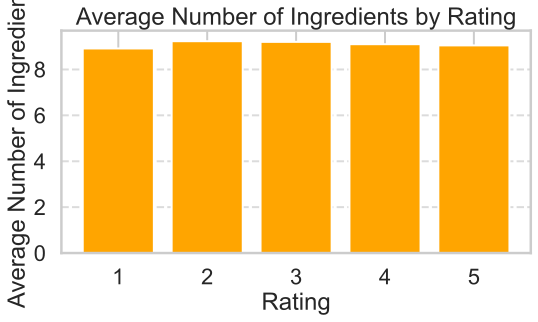

In [16]:
#Interesting Aggregates 
import matplotlib.pyplot as plt
df = recipe_interactions


agg1 = df.groupby('rating')['n_ingredients'].mean()

# Create the plot
plt.figure(figsize=(8, 5))
plt.bar(agg1.index, agg1.values, color="orange")
plt.title("Average Number of Ingredients by Rating")
plt.xlabel("Rating")
plt.ylabel("Average Number of Ingredients")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)  # Ensure the x-axis labels are horizontal
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()


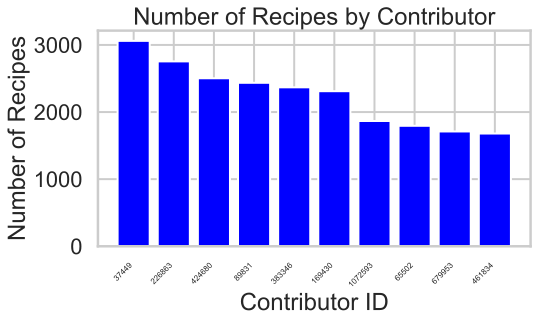

In [17]:
#2. Number of Recipes by Contributor for top 10 contributors 
agg2 = df["contributor_id"].value_counts()[:10]
agg2.index = agg2.index.astype(str)

# Create the plot
plt.figure(figsize=(8, 5))  # Set the figure size BEFORE plotting
plt.bar(agg2.index, agg2.values, color="blue")
plt.title("Number of Recipes by Contributor")
plt.xlabel("Contributor ID")
plt.ylabel("Number of Recipes")
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels diagonally and reduce font size
plt.tight_layout()  # Adjust layout to avoid clipping
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()


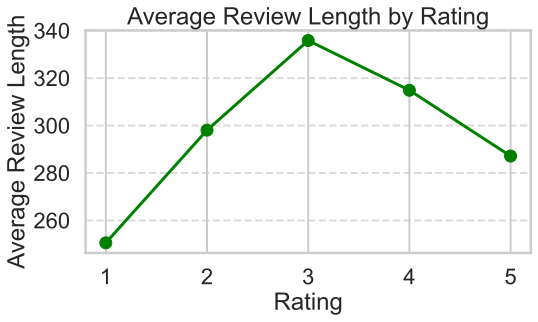

In [18]:
# 3. Average Review Length by Rating
agg3 = df.groupby("rating")["len_review"].mean()

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(agg3.index, agg3.values, marker="o", color="green")  # Explicitly use plot with x and y
plt.title("Average Review Length by Rating")
plt.xlabel("Rating")
plt.ylabel("Average Review Length")
plt.xticks(agg3.index, rotation=0)  # Ensure x-axis labels align with the index
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

## Step 3: Assessment of Missingness

In [19]:
#testing whether missingness of description is dependent on number of ingredients 
missing_test_df = recipe_interactions.copy()
missing_test_df["missing_description"] = missing_test_df['description'].isna()



group_means = missing_test_df.groupby("missing_description")["n_ingredients"].mean()
obs_stat = np.abs(group_means.loc[True] - group_means.loc[False])


n_repetitions = 1000 

missing_test_diffs = []

for i in range(n_repetitions): 
     missing_test_df["shuffled_missing"] = np.random.permutation(missing_test_df["missing_description"])
     description_stat = missing_test_df.groupby("shuffled_missing")["n_ingredients"].mean()
     description_stat = np.abs(description_stat.loc[True] - description_stat.loc[False])
     missing_test_diffs.append(description_stat)

missing_test_p_val = np.mean(missing_test_diffs >= obs_stat)


signficance_level = 0.05 

significant = missing_test_p_val < signficance_level

print(f"p value: {missing_test_p_val}")
print(f"significance level: {signficance_level}")
print(f"is description MAR dependent on number of ingredients? {significant}")


p value: 0.002
significance level: 0.05
is description MAR dependent on number of ingredients? True


In [20]:
#testing whether missingness of description is dependent on number of length of review
missing_test_df = recipe_interactions.copy()
missing_test_df["missing_description"] = missing_test_df['description'].isna()


missing_test_df['len_review'] = missing_test_df['review'].str.len()
group_means = missing_test_df.groupby("missing_description")["len_review"].mean()
obs_stat = np.abs(group_means.loc[True] - group_means.loc[False])


n_repetitions = 1000 

missing_test_diffs = []

for i in range(n_repetitions): 
     missing_test_df["shuffled_missing"] = np.random.permutation(missing_test_df["missing_description"])
     description_stat = missing_test_df.groupby("shuffled_missing")["len_review"].mean()
     description_stat = np.abs(description_stat.loc[True] - description_stat.loc[False])
     missing_test_diffs.append(description_stat)

missing_test_p_val = np.mean(missing_test_diffs >= obs_stat)


signficance_level = 0.05 

significant = missing_test_p_val < signficance_level

print(f"p value: {missing_test_p_val}")
print(f"significance level: {signficance_level}")
print(f"is description MAR dependent on number of length of review? {significant}")

p value: 0.886
significance level: 0.05
is description MAR dependent on number of length of review? False


## Step 4: Hypothesis Testing

In [21]:
#null hypothesis: The rating does not effect the number of steps 
#alternative hypothesis: The rating does have an effect on number of steps 

import scipy.stats as stats

df = recipe_interactions

# Assuming your dataset is already loaded into a DataFrame called `df`
# Ensure that the 'rating' and 'steps' columns are correctly named in the DataFrame
df = df.dropna(subset=['rating', 'n_steps'])  # Drop rows with missing values in 'rating' or 'steps'

# Group data by rating and extract the number of steps for each group
rating_groups = [df[df['rating'] == rating]['n_steps'] for rating in range(1, 6)]

# Perform one-way ANOVA test
f_stat, p_value = stats.f_oneway(*rating_groups)

f_stat

np.float64(49.82922822486933)

In [22]:
df['n_steps'].max()

np.int64(100)

In [23]:
#null hypothesis: the number of steps does not affect the rating of a recipe
#alternative hypothesis: the number of steps does affect the rating of a recipe

#first, we want to drop the rows where the rating is na (this will not help us for our permutation test)

hyp_df = recipe_interactions.copy()
hyp_df = hyp_df.dropna(subset= "rating")

#test statistic: tvd 
#the absolute deviation between the mean of each group and the total mean, divided bty 2 
obs_group_means = hyp_df.groupby("n_steps")["rating"].mean()
uniform_dist = [recipe_interactions["rating"].mean()] * len(obs_group_means)
obs_tvd =np.sum(
    np.abs(
    obs_group_means - uniform_dist
    )
) / 2

print(f"observed tvd: {obs_tvd}")

#making a new column of shuffled number test]
test_stats = []

for i in range(1000):
    hyp_df["shuffled_n_steps"] = np.random.permutation(hyp_df["n_steps"])
    test_group_means = hyp_df.groupby("shuffled_n_steps")["rating"].mean()
    emp_tvd = np.sum(np.abs(test_group_means - uniform_dist)) / 2
    test_stats.append(emp_tvd)

p_val = np.mean(test_stats >= obs_tvd)
print(f"p-value for permutation test: {p_val}")


observed tvd: 5.809777965286577
p-value for permutation test: 0.312


## Step 5: Framing a Prediction Problem

## Our prediction problem: Can we predict the category of cook time of a recipe, given other features? 

Our prediction problem is a classification problem, as we will create categorical "bins" for different ranges of cook times in minutes. The goal of our predictive model will be to predict the cook time category a specific recipe is in. 

In [ ]:
#here is the data cleaning that we did to get the features that we wanted for our model 

#want to create categories/bins for the minutes values 
def categorize_mins(time): 
    if time < 60: 
        return "Weekday"
    elif time < 180: 
        return "Weekend"
    elif time < 720: 
        return "Holiday/Special Occasion"
    else:
        return "Long Term Recipes"

#here we are cleaning the nutrition columns by converting it to a list instead of a string of a list   


model_recipe_interactions.drop(columns = ['name', 'id', 'contributor_id', 'submitted', 'steps', 'description', 'ingredients', 'user_id', 'date', 'rating', 'review'])


#dropping irrelavant features 
#recipe_id, contributor_id, date, name, rating, submitted, date, review, and other columns are not relevant 

model_recipe_interactions.head()

,name,id,minutes,contributor_id,...,minutes_category,is_dessert,calories,sodium
0,1 brownies in the world best ever,333281,40,985201,...,Weekday,1,138.4,3.0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,Weekday,0,595.1,22.0
2,412 broccoli casserole,306168,40,50969,...,Weekday,0,194.8,32.0
3,412 broccoli casserole,306168,40,50969,...,Weekday,0,194.8,32.0
4,412 broccoli casserole,306168,40,50969,...,Weekday,0,194.8,32.0


## Step 6: Baseline Model

In [25]:
#creating the training and testing data sets 

from sklearn.model_selection import train_test_split


In [26]:
#ANOTHER IDEA: make minutes into a categorical column and then try to predict the category that a recipe's time is in

#examples of categories: Weekday (less than an hour), Weekend (1-3 hours), Holiday/Special Occasion (3-12 hours), Long Term Recipes (> 12 hours)

#in order to do this, need to make new test and training data because we're now trying to predict a categorical variable instead of a numerical one 

cat_X_train, cat_X_test, cat_y_train, cat_y_test = train_test_split(model_recipe_interactions.drop(columns= ["minutes_category"]), model_recipe_interactions["minutes_category"])

cat_X_train.head()

,name,id,minutes,contributor_id,...,len_review,is_dessert,calories,sodium
185012,seasoned barbecued spareribs,476303,365,679953,...,191.0,0,1421.7,63.0
51939,chocolate silk pie with marshmallow meringue,432430,15,424680,...,131.0,1,357.1,17.0
59169,crab shrimp ravioli with saffron cream sauce,448376,140,1819179,...,308.0,0,932.9,46.0
137611,mini chocolate raspberry nut cups,413653,15,227978,...,284.0,1,47.7,0.0
102864,hawk s restaurant meatloaf very good,464274,115,24928,...,824.0,0,517.6,35.0


In [27]:

#new base model: categorize minutes and make a KNN classifier
from sklearn.neighbors import KNeighborsClassifier

cat1_X_train = cat_X_train[["n_ingredients", "n_steps"]]
cat1_y_train = cat_y_train 

cat1_X_test = cat_X_test[["n_ingredients", "n_steps"]]
cat1_y_test = cat_y_test
new_mdl = KNeighborsClassifier()

new_mdl.fit(cat1_X_train, cat1_y_train)

new_mdl.score(cat1_X_test, cat1_y_test)

0.7007917007917008

## Step 7: Final Model

In [28]:
# TODO

#only need to do cross validation for hyperparameters like n

#use grid search CV 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [29]:
#FINAL MODEL

#transformers: 
#want to standardize calories and sodium 
#desert is one hot encoded already technically 
#using n_ingredients and n_steps as is 

final_col_transform = ColumnTransformer(
    transformers= [("std_cals", StandardScaler(), ["calories"]),("std_sodium", StandardScaler(), ['sodium']) 
                   ], remainder = "passthrough"
)

final_pipe = Pipeline([
    ("column_transformations", final_col_transform), ("model", KNeighborsClassifier())
    ])

In [30]:
final_X_train = cat_X_train[["n_ingredients", "n_steps", "calories", "sodium", "is_dessert"]]
final_y_train = cat_y_train

final_X_test = cat_X_test[["n_ingredients", "n_steps", "calories", "sodium", "is_dessert"]]
final_y_test = cat_y_test



final_pipe.fit(final_X_train, final_y_train)

final_pipe.score(final_X_test, final_y_test)

0.8366434616434616

In [31]:
#Grid Search CV in order to find the best hyperparameters for the KNN classifier 
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 10],  # List of neighbors to try
    'weights': ['uniform', 'distance'],  # Weight options
    'metric': ['euclidean', 'manhattan']}  # Distance metric options 
grid_search = GridSearchCV(estimator= KNeighborsClassifier(), param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=1)

grid_search.fit(final_X_train, final_y_train)


best_params = grid_search.best_params_
best_final_model = grid_search.best_estimator_

best_final_model.score(final_X_train, final_y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


0.999823684315298

In [32]:
best_params

{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}

In [33]:
#OUR ACTUAL FINAL MODEL PIPELINE 
final_model_pipe = Pipeline([("column_transformer", final_col_transform), ("knn_model", KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance'))])

final_model_pipe.fit(final_X_train, final_y_train)

final_model_pipe.score(final_X_test, final_y_test)


0.9172809172809173

In [34]:
best_final_model_predicts = final_model_pipe.predict(final_X_test)

In [35]:
cat_X_test.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'user_id', 'date', 'rating', 'review', 'avg_rating',
       'len_review', 'is_dessert', 'calories', 'sodium'],
      dtype='object')

## Step 8: Fairness Analysis

In [36]:
fairness_df = cat_X_test.copy()
fairness_df["minutes_category"] = cat_y_test
fairness_df["low_rating"] = fairness_df["avg_rating"].apply(lambda x: x < 3)

fairness_df["predicted_label"] = best_final_model_predicts

fairness_df.columns




Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'user_id', 'date', 'rating', 'review', 'avg_rating',
       'len_review', 'is_dessert', 'calories', 'sodium', 'minutes_category',
       'low_rating', 'predicted_label'],
      dtype='object')

In [37]:
from sklearn.metrics import accuracy_score

get_accuracy = lambda x: accuracy_score(x['predicted_label'], x['minutes_category'])

obs_stat = (fairness_df
       .groupby('low_rating')
       [['predicted_label', 'minutes_category']]
       .apply(get_accuracy)
       .diff()
       .iloc[-1])

diff_in_acc = []
for _ in range(500):
    s = (
        fairness_df[['low_rating', 'predicted_label', 'minutes_category']]
        .assign(is_low=np.random.permutation(fairness_df['low_rating']))
        .groupby('is_low')
        [['predicted_label', 'minutes_category']]
        .apply(get_accuracy)
        .diff()
        .iloc[-1]
    )
    
    diff_in_acc.append(s)


p_val = np.mean(diff_in_acc >= obs_stat)
p_val

significant = p_val >= 0.05

print(f"{p_val} is our p_value")
print(f"model fair?: {significant}")

1.0 is our p_value
model fair?: True
